<a href="https://colab.research.google.com/github/Vinay3606/Caramount_prediction_project/blob/main/car_puchasing_amount_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Library**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# **Load Dataset**

In [4]:
df=pd.read_csv('/content/drive/MyDrive/ds project/Car_Purchasing_Data.csv',encoding='ISO-8859-1')

# **Data Validation And Feature Engineering**

In [5]:
df.head(10)

,Customer Name,Customer e-mail,Country,Gender,Age,Annual Salary,Credit Card Debt,Net Worth,Car Purchase Amount
0,Martina Avila,cubilia.Curae.Phasellus@quisaccumsanconvallis.edu,Bulgaria,0,41.851720,62812.09301,11609.380910,238961.2505,35321.45877
1,Harlan Barnes,eu.dolor@diam.co.uk,Belize,0,40.870623,66646.89292,9572.957136,530973.9078,45115.52566
2,Naomi Rodriquez,vulputate.mauris.sagittis@ametconsectetueradip...,Algeria,1,43.152897,53798.55112,11160.355060,638467.1773,42925.70921
3,Jade Cunningham,malesuada@dignissim.com,Cook Islands,1,58.271369,79370.03798,14426.164850,548599.0524,67422.36313
4,Cedric Leach,felis.ullamcorper.viverra@egetmollislectus.net,Brazil,1,57.313749,59729.15130,5358.712177,560304.0671,55915.46248
5,Carla Hester,mi@Aliquamerat.edu,Liberia,1,56.824893,68499.85162,14179.472440,428485.3604,56611.99784
6,Griffin Rivera,vehicula@at.co.uk,Syria,1,46.607315,39814.52200,5958.460188,326373.1812,28925.70549
7,Orli Casey,nunc.est.mollis@Suspendissetristiqueneque.co.uk,Czech Republic,1,50.193016,51752.23445,10985.696560,629312.4041,47434.98265
8,Marny Obrien,Phasellus@sedsemegestas.org,Armenia,0,46.584745,58139.25910,3440.823799,630059.0274,48013.61410
9,Rhonda Chavez,nec@nuncest.com,Somalia,1,43.323782,53457.10132,12884.078680,476643.3544,38189.50601


In [6]:
df['Debt_Income_Ratio'] = df['Credit Card Debt'] / df['Annual Salary']


In [31]:
# Check for missing values
print(df.isnull().sum())

# Outlier detection (example with IQR)
for col in [ 'Annual Salary', 'Credit Card Debt', 'Net Worth']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    df = df[(df[col] >= Q1 - 1.5 * IQR) & (df[col] <= Q3 + 1.5 * IQR)]


Customer Name          0
Customer e-mail        0
Country                0
Gender                 0
Age                    0
Annual Salary          0
Credit Card Debt       0
Net Worth              0
Car Purchase Amount    0
Debt_Income_Ratio      0
dtype: int64


In [8]:
df.columns

Index(['Customer Name', 'Customer e-mail', 'Country', 'Gender', 'Age',
       'Annual Salary', 'Credit Card Debt', 'Net Worth', 'Car Purchase Amount',
       'Debt_Income_Ratio'],
      dtype='object')

# **Feature Selection And Encoding**

In [11]:
x=df[[ 'Gender', 'Age',
       'Annual Salary', 'Credit Card Debt', 'Net Worth',
       'Debt_Income_Ratio']]

In [12]:
y=df['Car Purchase Amount']

In [33]:
# Industry standard: Pipeline + ColumnTransformer
categorical_features = ['Gender']
numeric_features = ['Age', 'Annual Salary', 'Credit Card Debt', 'Net Worth', 'Debt_Income_Ratio']

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
# Preprocessing pipeline
pps = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),  # Or StandardScaler() if distribution is normal[3][7]
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ]
)

# **Train-Test Split**

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [19]:
X_train.shape

(388, 6)

In [20]:
X_test.shape

(98, 6)

In [21]:
df.shape

(486, 10)

# **Preprocessing And Scaling**

In [26]:
X_train_processed = pps.fit_transform(X_train)
X_test_processed = pps.transform(X_test)

# Scale target variable
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))


# **Build Neural Network**

In [34]:

from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import joblib
import tensorflow as tf

model = Sequential([
    Dense(32, input_dim=X_train_processed.shape[1], activation='relu'),
    Dense(32, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)




/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


# **Train Model**

In [35]:
history = model.fit(
    X_train_processed, y_train_scaled,
    epochs=100,
    batch_size=25,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1747 - val_loss: 0.0375
Epoch 2/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0283 - val_loss: 0.0232
Epoch 3/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0202 - val_loss: 0.0140
Epoch 4/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0114 - val_loss: 0.0116
Epoch 5/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0085 - val_loss: 0.0084
Epoch 6/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 7/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0045 - val_loss: 0.0046
Epoch 8/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0035 - val_loss: 0.0033
Epoch 9/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 12/100
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step -

# **Evalution Model**

In [37]:

y_pred_scaled = model.predict(X_test_processed)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test_scaled)


print("R² Score:", r2_score(y_test_actual, y_pred))
print("MSE:", mean_squared_error(y_test_actual, y_pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
R² Score: 0.9956860292614136
MSE: 451722.8676625147


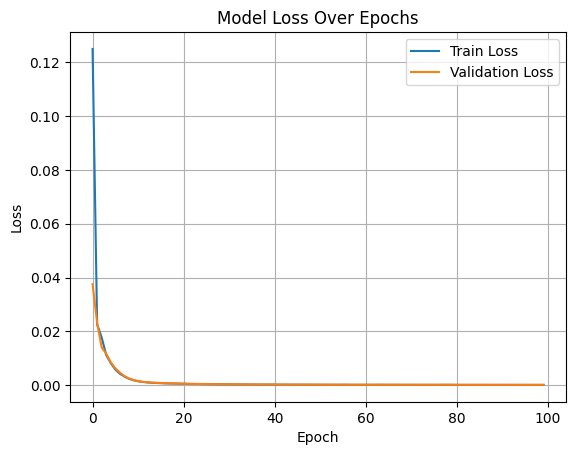

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Validation Loss'])
plt.grid(True)
plt.show()



# **Save the Model**

In [29]:
model.save('car_purchase_model.h5')
joblib.dump(pps, 'preprocessor.pkl')
joblib.dump(scaler, 'y_scaler.pkl')


['y_scaler.pkl']

# **Predict On New Sample**

In [41]:
sample = pd.DataFrame([[0, 41.85172, 62812.09301, 11609.38091, 238961.2505, 11609.38091/62812.09301]], columns=x.columns)
sample_processed = pps.transform(sample)
pred_scaled = model.predict(sample_processed)
pred_actual = scaler.inverse_transform(pred_scaled)

print("Predicted Car Purchase Amount:", pred_actual[0][0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted Car Purchase Amount: 34960.58
